In [11]:
from numpy import linalg as LA
import os
import pandas as pd
import numpy as np
from scipy.signal import find_peaks_cwt
import pickle
from pathlib import Path
from scipy.stats import kurtosis, skew
from scipy.stats import iqr
from pyentrp import entropy as ent
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, LSTMCell
from keras.layers import Dropout
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize
import sys
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
in_dir = "data_3_7_2018"

## Compute features for accelerometer only

In [6]:
trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

#Helper Functions

def Signal_magnitude_area(x,y,z):
    
    sum = 0    
    for i in range(len(x)):
        sum += (abs(x[i]) + abs(y[i]) + abs(z[i]))
        
    return float(sum)/len(x)


def Power(x):
    
    power = (LA.norm(x)**2)/ len(x)
    return power
    
def number_of_peaks(window):
    indexes = find_peaks_cwt(window, np.arange(1, len(window)))

    return len(indexes)

#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df
    

dfs_list = []
features = []
labels = []

pickle_file = Path("pickles/accelerometer_features.pickle")

if pickle_file.exists():
    print("Found pickle files for accelerometer")
    
    features = pickle.load(open("pickles/accelerometer_features.pickle", "rb"))
    labels = pickle.load(open("pickles/accelerometer_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/accelerometer_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:
            print("/".join(path) + "/" + f)

            full_path = "/".join(path) + "/" + f

            if "gyroscope" in full_path:
                print("Skip ", full_path)
                continue

            df = pd.read_csv(full_path, header=None)

            print("Before trimming: ", df.shape)
            
            df = trim_first_last_n_seconds(df, trim_num_seconds, acc_freq)
            if df is None:
                print("Continuing")
                continue

            print("After trimming: ", df.shape)

            #Sample the data according to the size of the window with 50% overlap
            for index in range(0, df.shape[0]-window_size, window_jump_steps):
                indexes = list(range(index, index + int(window_size)))

                window = df.iloc[indexes,:]

                X_list = window[1].tolist()
                Y_list = window[2].tolist()
                Z_list = window[3].tolist()
                
                
                #Generate the features for this window
                
                
       # ****************** Time-Domain Features ************************* #
    
                #Mean of the signals
                mean_x = np.mean(X_list)
                mean_y = np.mean(Y_list)
                mean_z = np.mean(Z_list)

                #Variance of the signals
                var_x = np.var(X_list)
                var_y = np.var(Y_list)
                var_z = np.var(Z_list)

                #Number of peaks in the signals
                #num_peaks_x = number_of_peaks(X_list)
                #num_peaks_y = number_of_peaks(Y_list)
                #num_peaks_z = number_of_peaks(Z_list)            

                #Median of the signals
                median_x = np.ma.median(X_list)
                median_y = np.ma.median(Y_list)
                median_z = np.ma.median(Z_list)
              
                #Standard Deviation of the signals
                std_x = np.std(X_list)
                std_y = np.std(Y_list)
                std_z = np.std(Z_list)
                               
                #Compute Signal Magnitude Area
                signal_mag_area = Signal_magnitude_area(X_list, Y_list, Z_list)
                               
                #Maximum and Minimum values and their indexes
                max_x = max(X_list)
                max_index_x = X_list.index(max_x)               
                min_x = min(X_list)
                min_index_x = X_list.index(min_x)
               
                max_y = max(Y_list)
                max_index_y = Y_list.index(max_y)              
                min_y = min(Y_list)
                min_index_y = Y_list.index(min_y)               
                
                max_z = max(Z_list)
                max_index_z = Z_list.index(max_z)             
                min_z = min(Z_list)
                min_index_z = Z_list.index(min_z)
                
                
                #Power of X,Y and Z signals             
                power_x = Power(X_list)
                power_y = Power(Y_list)
                power_z = Power(Z_list)
                
                
                #Skewness and Kurtosis
                skew_x = skew(X_list)
                skew_y = skew(Y_list)
                skew_z = skew(Z_list)
                
                kurtosis_x = kurtosis(X_list)                
                kurtosis_y = kurtosis(Y_list)
                kurtosis_z = kurtosis(Z_list)
                
                
                #Entropy of the signals (Can experiment with different types of Entropy)
                entropy_x = ent.shannon_entropy(X_list)
                entropy_y = ent.shannon_entropy(Y_list)
                entropy_z = ent.shannon_entropy(Z_list)
                
                
                #Interquartile range of the signals
                iqr_x = iqr(X_list)
                iqr_y = iqr(Y_list)
                iqr_z = iqr(Z_list)
               
    
    # ****************** Frequency-Domain Features ************************* #
                
                #Normalized FFT coefficients
                fft_x = LA.norm(np.fft.rfft(X_list))              
                fft_y = LA.norm(np.fft.rfft(Y_list))   
                fft_z = LA.norm(np.fft.rfft(Z_list))  
                
                
                #Store the features
                window_feature = []
                window_feature.append(mean_x)
                window_feature.append(mean_y)
                window_feature.append(mean_z)
                
                window_feature.append(var_x)
                window_feature.append(var_y)
                window_feature.append(var_z)
                
                window_feature.append(median_x)
                window_feature.append(median_y)
                window_feature.append(median_z)
                
                window_feature.append(std_x)
                window_feature.append(std_y)
                window_feature.append(std_z)
                
                
                window_feature.append(signal_mag_area)
                
                window_feature.append(max_x)
                window_feature.append(max_index_x)
                window_feature.append(min_x)
                window_feature.append(min_index_x)
                
                window_feature.append(max_y)
                window_feature.append(max_index_y)
                window_feature.append(min_y)
                window_feature.append(min_index_y)
                
                window_feature.append(max_z)
                window_feature.append(max_index_z)
                window_feature.append(min_z)
                window_feature.append(min_index_z)
                
                window_feature.append(power_x)
                window_feature.append(power_y)
                window_feature.append(power_z)
                
                window_feature.append(skew_x)
                window_feature.append(kurtosis_x) 
                
                window_feature.append(skew_y)
                window_feature.append(kurtosis_y) 
                
                window_feature.append(skew_z)
                window_feature.append(kurtosis_z) 
                
                window_feature.append(entropy_x)
                window_feature.append(entropy_y)
                window_feature.append(entropy_z)
                
                window_feature.append(iqr_x)
                window_feature.append(iqr_y)
                window_feature.append(iqr_z)
                
                window_feature.append(fft_x)
                window_feature.append(fft_y)
                window_feature.append(fft_z)
                
                
                #window_feature.append(num_peaks_x)
                #window_feature.append(num_peaks_y)
                #window_feature.append(num_peaks_z)
               
                #scale = preprocessing.minmax_scale(data, feature_range=(-0.5, 0.5))

                features.append(window_feature)

                #Store the label
                labels.append(df[5].iloc[1])

            dfs_list.append(df)

    dfs = pd.concat(dfs_list)

    pickle.dump(features, open("pickles/accelerometer_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/accelerometer_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/accelerometer_dfs_list.pickle", "wb"), protocol=2)

features = np.asarray(features)
labels = np.asarray(labels)

Window_size, Window_jump_steps:  1000 500
data_3_7_2018/0_1_android.sensor.accelerometer.data.csv
Before trimming:  (64964, 6)
After trimming:  (59965, 6)
data_3_7_2018/0_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/0_4_android.sensor.gyroscope.data.csv
data_3_7_2018/10_1_android.sensor.accelerometer.data.csv
Before trimming:  (64675, 6)
After trimming:  (59676, 6)
data_3_7_2018/10_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/10_4_android.sensor.gyroscope.data.csv
data_3_7_2018/11_1_android.sensor.accelerometer.data.csv
Before trimming:  (66938, 6)
After trimming:  (61939, 6)
data_3_7_2018/11_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/11_4_android.sensor.gyroscope.data.csv
data_3_7_2018/12_1_android.sensor.accelerometer.data.csv
Before trimming:  (60980, 6)
After trimming:  (55981, 6)
data_3_7_2018/12_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/12_4_android.sensor.gyroscope.data.csv
data_3_7_2018/13_1_android.sensor.accelerometer.data.csv


data_3_7_2018/42_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/42_4_android.sensor.gyroscope.data.csv
data_3_7_2018/43_1_android.sensor.accelerometer.data.csv
Before trimming:  (52974, 6)
After trimming:  (47975, 6)
data_3_7_2018/43_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/43_4_android.sensor.gyroscope.data.csv
data_3_7_2018/44_1_android.sensor.accelerometer.data.csv
Before trimming:  (147020, 6)
After trimming:  (142021, 6)
data_3_7_2018/44_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/44_4_android.sensor.gyroscope.data.csv
data_3_7_2018/45_1_android.sensor.accelerometer.data.csv
Before trimming:  (99784, 6)
After trimming:  (94785, 6)
data_3_7_2018/45_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/45_4_android.sensor.gyroscope.data.csv
data_3_7_2018/46_1_android.sensor.accelerometer.data.csv
Before trimming:  (9650, 6)
After trimming:  (4651, 6)
data_3_7_2018/46_4_android.sensor.gyroscope.data.csv
Skip  data_3_7_2018/46_4_android.sensor.gyr

In [8]:
print(features.shape)
print(labels.shape)

(8196, 43)
(8196,)


['laying_down' 'sitting' 'standing' 'walking']


(array([1947.,    0.,    0., 2842.,    0.,    0., 1656.,    0.,    0.,
        1751.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

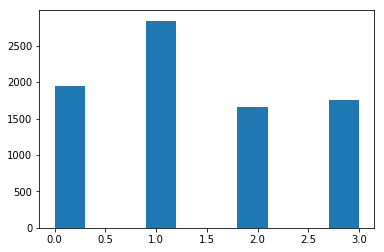

In [13]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(labels)

print(le.classes_)

plt.hist(y)

# Compute features for accelerometer and gyrometer

In [ ]:

in_dir = "data_3_4_2018"

trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

def number_of_peaks(window):
    indexes = find_peaks_cwt(window, np.arange(1, len(window)))

    return len(indexes)

#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df
    
def combine_acc_gyro_data(df_acc, df_gyro):
    threshold = 10
    
    acc_index = 0
    gyro_index = 0
    
    acc_matrix = df_acc.as_matrix()
    gyro_matrix = df_gyro.as_matrix()
    
    combined_list = []
    
    while (acc_index < df_acc.shape[0]) and (gyro_index < df_gyro.shape[0]):
        #find next gyro_index within threshold and append the data
        
        acc_time = df_acc.iloc[acc_index][0]
        gyro_time = df_gyro.iloc[gyro_index][0]

        if (acc_time < gyro_time):
            while (acc_index < df_acc.shape[0]) and (gyro_time - acc_time > threshold):
                acc_time = acc_matrix[acc_index][0] #df_acc.iloc[acc_index][0]
                acc_index += 1
        else:
            while (gyro_index < df_gyro.shape[0]) and (acc_time - gyro_time > threshold):
                gyro_time = gyro_matrix[gyro_index][0] #df_gyro.iloc[gyro_index][0]
                gyro_index += 1
            
        combined_list.append(np.concatenate((acc_matrix[acc_index][:4], gyro_matrix[gyro_index][1:6]), axis=0))
        acc_index += 1
        gyro_index += 1
            
    return combined_list


dfs_list = []
features = []
labels = []

pickle_file = Path("pickles/acc_gyro_features.pickle")

if pickle_file.exists():
    print("Found pickle files for accelerometer and gyroscope features combined")
    
    features = pickle.load(open("pickles/acc_gyro_features.pickle", "rb"))
    labels = pickle.load(open("pickles/acc_gyro_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/acc_gyro_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            if 'accelerometer' in f:
                accelerometer_path = "/".join(path) + "/" + f
                print(accelerometer_path)

                first_ = f.find("_")
                g = f[0:first_] + "_4" + f[first_+2:]
                gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
                print(gyroscope_path)

                df_acc = pd.read_csv(accelerometer_path, header=None)
                df_gyro = pd.read_csv(gyroscope_path, header=None)

                combined_list = combine_acc_gyro_data(df_acc, df_gyro)
                combined_numpy = np.array(combined_list)

                combined_df = pd.DataFrame(data=combined_numpy)

                print("Before trimming: ", combined_df.shape)

                combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
                if combined_df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", combined_df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = combined_df.iloc[indexes,:]

                    #Generate the features for this window
                    acc_mean_x = np.mean(window[1].tolist())
                    acc_mean_y = np.mean(window[2].tolist())
                    acc_mean_z = np.mean(window[3].tolist())

                    acc_var_x = np.var(window[1].tolist())
                    acc_var_y = np.var(window[2].tolist())
                    acc_var_z = np.var(window[3].tolist())

#                     acc_num_peaks_x = number_of_peaks(window[1].tolist())
#                     acc_num_peaks_y = number_of_peaks(window[2].tolist())
#                     acc_num_peaks_z = number_of_peaks(window[3].tolist())            

                    window_feature = []

                    window_feature.append(acc_mean_x)
                    window_feature.append(acc_mean_y)
                    window_feature.append(acc_mean_z)
                    window_feature.append(acc_var_x)
                    window_feature.append(acc_var_y)
                    window_feature.append(acc_var_z)
#                     window_feature.append(acc_num_peaks_x)
#                     window_feature.append(acc_num_peaks_y)
#                     window_feature.append(acc_num_peaks_z)


                    gyro_mean_x = np.mean(window[4].tolist())
                    gyro_mean_y = np.mean(window[5].tolist())
                    gyro_mean_z = np.mean(window[6].tolist())

                    gyro_var_x = np.var(window[4].tolist())
                    gyro_var_y = np.var(window[5].tolist())
                    gyro_var_z = np.var(window[6].tolist())

#                     gyro_num_peaks_x = number_of_peaks(window[4].tolist())
#                     gyro_num_peaks_y = number_of_peaks(window[5].tolist())
#                     gyro_num_peaks_z = number_of_peaks(window[6].tolist())            

                    #Store the features
                    
                    window_feature.append(gyro_mean_x)
                    window_feature.append(gyro_mean_y)
                    window_feature.append(gyro_mean_z)
                    window_feature.append(gyro_var_x)
                    window_feature.append(gyro_var_y)
                    window_feature.append(gyro_var_z)
#                     window_feature.append(gyro_num_peaks_x)
#                     window_feature.append(gyro_num_peaks_y)
#                     window_feature.append(gyro_num_peaks_z)

                    features.append(window_feature)

                    #Store the label
                    labels.append(combined_df[8].iloc[0])
                
                dfs_list.append(combined_df)
            
    dfs = pd.concat(dfs_list)

    pickle.dump(features, open("pickles/acc_gyro_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/acc_gyro_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/acc_gyro_dfs_list.pickle", "wb"), protocol=2)

features = np.asarray(features)
labels = np.asarray(labels)

Window_size, Window_jump_steps:  1000 500
data_3_4_2018/0_1_android.sensor.accelerometer.data.csv
data_3_4_2018/0_4_android.sensor.gyroscope.data.csv
Before trimming:  (34142, 9)
After trimming:  (29143, 9)
data_3_4_2018/10_1_android.sensor.accelerometer.data.csv
data_3_4_2018/10_4_android.sensor.gyroscope.data.csv
Before trimming:  (34053, 9)
After trimming:  (29054, 9)
data_3_4_2018/11_1_android.sensor.accelerometer.data.csv
data_3_4_2018/11_4_android.sensor.gyroscope.data.csv
Before trimming:  (34366, 9)
After trimming:  (29367, 9)
data_3_4_2018/12_1_android.sensor.accelerometer.data.csv
data_3_4_2018/12_4_android.sensor.gyroscope.data.csv
Before trimming:  (31982, 9)
After trimming:  (26983, 9)
data_3_4_2018/13_1_android.sensor.accelerometer.data.csv
data_3_4_2018/13_4_android.sensor.gyroscope.data.csv
Before trimming:  (40277, 9)
After trimming:  (35278, 9)
data_3_4_2018/14_1_android.sensor.accelerometer.data.csv
data_3_4_2018/14_4_android.sensor.gyroscope.data.csv
Before trimming

## Compute LSTM features for accelerometer

In [28]:
trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

dfs_list = []
features = []
labels = []


#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df


pickle_file = Path("pickles/lstm_acc_features.pickle")

if pickle_file.exists():
    print("Found pickle files for LSTM acc and gyro")
    
    features = pickle.load(open("pickles/lstm_acc_features.pickle", "rb"))
    labels = pickle.load(open("pickles/lstm_acc_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/lstm_acc_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            accelerometer_path = "/".join(path) + "/" + f
            print(accelerometer_path)

            first_ = f.find("_")
            g = f[0:first_] + "_4" + f[first_+2:]
            gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
            print(gyroscope_path)

            df_acc = pd.read_csv(accelerometer_path, header=None)
            df_gyro = pd.read_csv(gyroscope_path, header=None)

            combined_list = combine_acc_gyro_data(df_acc, df_gyro)
            combined_numpy = np.array(combined_list)

            combined_df = pd.DataFrame(data=combined_numpy)

            print("Before trimming: ", combined_df.shape)

            combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
            if combined_df is None:
                print("Continuing")
                continue

            print("After trimming: ", combined_df.shape)

            #Sample the data according to the size of the window with 50% overlap
            for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                indexes = list(range(index, index + int(window_size)))

                window = df.iloc[indexes, 1:df.shape[1]-2]

                #Generate the features for this window            
                features.append(np.asarray(window))

                #Store the label
                labels.append(df[5].iloc[0])

            dfs_list.append(df)

    dfs = pd.concat(dfs_list)
    
    pickle.dump(features, open("pickles/lstm_acc_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/lstm_acc_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/lstm_acc_dfs_list.pickle", "wb"), protocol=2)
    
    
features = np.asarray(features)
labels = np.asarray(labels)    

Window_size, Window_jump_steps:  1000 500
data_3_4_2018/0_1_android.sensor.accelerometer.data.csv
Before trimming:  (64964, 6)
After trimming:  (59965, 6)
data_3_4_2018/10_1_android.sensor.accelerometer.data.csv
Before trimming:  (64675, 6)
After trimming:  (59676, 6)
data_3_4_2018/11_1_android.sensor.accelerometer.data.csv
Before trimming:  (66938, 6)
After trimming:  (61939, 6)
data_3_4_2018/12_1_android.sensor.accelerometer.data.csv
Before trimming:  (60980, 6)
After trimming:  (55981, 6)
data_3_4_2018/13_1_android.sensor.accelerometer.data.csv
Before trimming:  (62506, 6)
After trimming:  (57507, 6)
data_3_4_2018/14_1_android.sensor.accelerometer.data.csv
Before trimming:  (65108, 6)
After trimming:  (60109, 6)
data_3_4_2018/15_1_android.sensor.accelerometer.data.csv
Before trimming:  (62588, 6)
After trimming:  (57589, 6)
data_3_4_2018/16_1_android.sensor.accelerometer.data.csv
Before trimming:  (82181, 6)
After trimming:  (77182, 6)
data_3_4_2018/17_1_android.sensor.accelerometer

## Compute LSTM features for accelerometer and gyroscope

In [31]:
trim_num_seconds = 10
acc_freq = 4
window_num_seconds = 4 #seconds
steps_per_sec = int(1000/acc_freq)
window_size = int(window_num_seconds*steps_per_sec)
window_step = 2 #seconds
window_jump_steps = int(window_step*steps_per_sec)

print("Window_size, Window_jump_steps: ", window_size, window_jump_steps)

dfs_list = []
features = []
labels = []


#this function assumes that records are evenly spaced
def trim_first_last_n_seconds(df, n, freq):
    if df.shape[0] < 6001:
        return None
    
    remove_indexes = list(range(0, int(n*1000/freq)))
    df = df.drop(remove_indexes)

    remove_indexes = list(range(df.shape[0] - int(n*1000/freq), df.shape[0]-1))
    df = df.drop(remove_indexes)
    
    return df

def combine_acc_gyro_data(df_acc, df_gyro):
    threshold = 10
    
    acc_index = 0
    gyro_index = 0
    
    acc_matrix = df_acc.as_matrix()
    gyro_matrix = df_gyro.as_matrix()
    
    combined_list = []
    
    while (acc_index < df_acc.shape[0]) and (gyro_index < df_gyro.shape[0]):
        #find next gyro_index within threshold and append the data
        
        acc_time = df_acc.iloc[acc_index][0]
        gyro_time = df_gyro.iloc[gyro_index][0]

        if (acc_time < gyro_time):
            while (acc_index < df_acc.shape[0]) and (gyro_time - acc_time > threshold):
                acc_time = acc_matrix[acc_index][0] #df_acc.iloc[acc_index][0]
                acc_index += 1
        else:
            while (gyro_index < df_gyro.shape[0]) and (acc_time - gyro_time > threshold):
                gyro_time = gyro_matrix[gyro_index][0] #df_gyro.iloc[gyro_index][0]
                gyro_index += 1
            
        combined_list.append(np.concatenate((acc_matrix[acc_index][:4], gyro_matrix[gyro_index][1:6]), axis=0))
        acc_index += 1
        gyro_index += 1
            
    return combined_list


pickle_file = Path("pickles/lstm_acc_gyro_features.pickle")

if pickle_file.exists():
    print("Found pickle files for LSTM acc and gyro")
    
    features = pickle.load(open("pickles/lstm_acc_gyro_features.pickle", "rb"))
    labels = pickle.load(open("pickles/lstm_acc_gyro_labels.pickle", "rb"))
    dfs_list = pickle.load(open("pickles/lstm_acc_gyro_dfs_list.pickle", "rb"))
    
else:

    for root, dirs, files in os.walk(in_dir):
        path = root.split(os.sep)

        for f in files:

            if 'accelerometer' in f:
                accelerometer_path = "/".join(path) + "/" + f
                print(accelerometer_path)

                first_ = f.find("_")
                g = f[0:first_] + "_4" + f[first_+2:]
                gyroscope_path = "/".join(path) + "/" + g.replace("accelerometer","gyroscope")
                print(gyroscope_path)

                df_acc = pd.read_csv(accelerometer_path, header=None)
                df_gyro = pd.read_csv(gyroscope_path, header=None)

                combined_list = combine_acc_gyro_data(df_acc, df_gyro)
                combined_numpy = np.array(combined_list)

                combined_df = pd.DataFrame(data=combined_numpy)

                print("Before trimming: ", combined_df.shape)

                combined_df = trim_first_last_n_seconds(combined_df, trim_num_seconds, acc_freq)
                if combined_df is None:
                    print("Continuing")
                    continue

                print("After trimming: ", combined_df.shape)

                #Sample the data according to the size of the window with 50% overlap
                for index in range(0, combined_df.shape[0]-window_size, window_jump_steps):
                    indexes = list(range(index, index + int(window_size)))

                    window = combined_df.iloc[indexes, 1:7] #,1:combined_df.shape[1]-2]

                    #Generate the features for this window            
                    features.append(np.asarray(window))

                    #Store the label
                    labels.append(combined_df[8].iloc[0])

                dfs_list.append(combined_df)

    dfs = pd.concat(dfs_list)
    
    pickle.dump(features, open("pickles/lstm_acc_gyro_features.pickle", "wb"), protocol=2)
    pickle.dump(labels, open("pickles/lstm_acc_gyro_labels.pickle", "wb"), protocol=2)
    pickle.dump(dfs_list, open("pickles/lstm_acc_gyro_dfs_list.pickle", "wb"), protocol=2)
    
    
features = np.asarray(features)
labels = np.asarray(labels)    

Window_size, Window_jump_steps:  1000 500
Found pickle files for LSTM acc and gyro


## Utility functions

In [18]:
def getModel(modelName, args):
    
    if modelName == 'LogisticRegression':
        model = LogisticRegression(random_state=42)
        
    if modelName == 'SVC':
        model = SVC(random_state=42, kernel=args[0], C=args[1], decision_function_shape=args[2])
        
    if modelName == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(random_state=42, max_features=args[0], criterion=args[1])
        
    if modelName == 'RandomForestClassifier':
        model = RandomForestClassifier(n_estimators=args[0], criterion=args[1], max_features=args[2], max_depth=args[3], oob_score=True, random_state=42)
        
    if modelName == 'MLPClassifier':
        model = MLPClassifier(hidden_layer_sizes=args[0], activation=args[1], solver=args[2], random_state=42, max_iter=500)
        
    return model

In [19]:

def run_kfold(features, labels, num_splits, modelName, args=None, verbose=False):
    
    X = np.array(normalize(features))
    y = np.array(labels)

    kf = KFold(n_splits=num_splits, random_state=None, shuffle=True)
    kf.get_n_splits(X)

    foldAccuracy = list()
    foldPrecision = list()
    foldRecall = list()
    bestModel = None
    bestAccuracy = float(sys.maxsize) * (-1)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = getModel(modelName, args)

        model.fit(X_train, y_train)

        prediction = model.predict(X_test)

        if verbose:
            print("\nFold: ", fold)
            print("Confusion Matrix:")
            cm = metrics.confusion_matrix(yTest, prediction)
            print(cm)
            plt.matshow(cm, cmap = plt.cm.Oranges)
            plt.title('Confusion matrix')
            plt.colorbar()
            plt.ylabel('True label')
            plt.xlabel('Predicted label')
            plt.show()

        accuracy = metrics.accuracy_score(y_test, prediction)
        precision = metrics.precision_score(y_test, prediction, average = None)
        recall = metrics.recall_score(y_test, prediction, average = None)

        foldAccuracy.append(accuracy)
        foldPrecision.append(precision)
        foldRecall.append(recall)
        
        if accuracy > bestAccuracy:
            bestAccuracy = accuracy
            bestModel = model
                
    print("\nBest Accuracy: ", bestAccuracy)
    
    return bestModel, foldAccuracy, foldPrecision, foldRecall        

In [15]:
#Filter data to select some specific features from all the list of features for the model training

features_to_consider = [0,1,2,3,4,5,6,7,8,9,10,11]
features_new = []

for feature in features:
    
    feat = []
    for index in features_to_consider:
        feat.append(feature[index])
        
    features_new.append(feat)

features_new = numpy.array(features_new)

In [16]:
features_new[1]

array([-2.67587902e+00,  2.17294647e-02,  9.13332639e+00,  7.17382979e-04,
        1.91591425e-03,  7.78390033e-04, -2.67608980e+00,  2.39364020e-02,
        9.12934300e+00,  2.67840060e-02,  4.37711578e-02,  2.78996422e-02])

## Logistic Regression

In [20]:
num_splits = 5

lrModel, lrAccuracy, lrPrecision, lrRecall = run_kfold(features_new, labels, num_splits, 'LogisticRegression')


Best Accuracy:  0.7882855399633923


## SVM

In [21]:
#hard margin SVM 1

#kernel = 'rbf'
#C = 1000
#decision_function_shape = 'ovo'

num_splits = 5
args = ['rbf', 1000, 'ovo']

hmSVC1Model, hmSVC1Accuracy, hmSVC1Precision, hmSVC1Recall = run_kfold(features_new, labels, num_splits, 'SVC', args)


Best Accuracy:  0.8547895057962172


## Decision Tree

In [22]:
#decision Tree 1

#max_features = 6
#criterion = 'gini'

num_splits = 5
args = [6, 'gini']

dt1Model, dt1Accuracy, dt1Precision, dt1Recall = run_kfold(features_new, labels, num_splits, 'DecisionTreeClassifier', args)


Best Accuracy:  0.8871262965222697


## Random Forest

In [23]:
#random Forest Classification 1

#n_estimators = 20
#criterion = gini
#max_features = 6
#max_depth = 5

num_splits = 5
args = [20, 'gini', 6, 8]

rf1Model, rf1Accuracy, rf1Precision, rf1Recall = run_kfold(features_new, labels, num_splits, 'RandomForestClassifier', args)

c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\users\sharm\appdata\l


Best Accuracy:  0.8822452715070165


c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\users\sharm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


## MLP classifier

In [24]:
#Multi Layer Perceptron Classification 

#hidden_layer_sizes = 50
#activation = tanh
#solver = lbfgs

num_splits = 5
args = [(50,100), 'tanh', 'lbfgs']

mlp2Model, mlp2Accuracy, mlp2Precision, mlp2Recall = run_kfold(features_new, labels, num_splits, 'MLPClassifier', args)


Best Accuracy:  0.9243441122635754


## LSTM

In [34]:

def run_lstm(features, labels, train_test_split_ratio, batch_size, epochs):

    X = features

    y = np.array(labels)
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)

    y = y.reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=train_test_split_ratio, random_state=42)

    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train[0].shape[0], X_train[0].shape[1]), return_sequences=True))
    model.add(LSTM(100))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()

    model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

    #Evaluate the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    predicted_labels = model.predict(X_test)

    print("Accuracy: ", scores[1]*100)

    def get_hot_value(my_list):
        max_val = max(my_list)
        return [int(item == max_val) for item in my_list]

    hot_list = [get_hot_value(sublist) for sublist in predicted_labels]

    t  = np.array(y_test)
    p  = np.array(hot_list)
    t = np.argmax(t, axis=1)
    p = np.argmax(p, axis=1)

    print("Precision: ", precision_score(t, p, average=None))
    

In [36]:
train_test_split_ratio = 0.1
batch_size = 300
epochs = 100

run_lstm(features, labels, train_test_split_ratio, batch_size, epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1000, 100)         42800     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 123,604
Trainable params: 123,604
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
 600/3808 [===>..........................] - ETA: 1:39 - loss: 1.4339 - acc: 0.2633

KeyboardInterrupt: 